# EDA, Text, Processing, and Feature Engineering

In [300]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in DataFrame

In [140]:
df = pd.read_csv('data/poetry_foundation_raw_rescrape.csv', index_col=0)
df.head()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string
0,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48578/at-the-california-institute-of-technology,Richard Brautigan,At the California Institute of Technology,"['I don’t care how God-damn smart', '\r these guys are: I’m bored.', '', '\r It’s been raining like hell all day long', '\r and there’s nothing to...",I don’t care how God-damn smart\n\r these guys are: I’m bored.\n\n\r It’s been raining like hell all day long\n\r and there’s nothing to do.\n
1,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48576/a-boat,Richard Brautigan,A Boat,"['O beautiful ', 'was the werewolf ', 'in his evil forest. ', 'We took him ', 'to the carnival ', 'and he started ', ' crying ', 'when h...",O beautiful \nwas the werewolf \nin his evil forest. \nWe took him \nto the carnival \nand he started \n crying \nwhen he saw \nthe Ferr...
2,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48580/december-30,Richard Brautigan,December 30,"['At 1:03 in the morning a fart', '\r smells like a marriage between', '\r an avocado and a fish head.', '', '\r I have to get out of bed', '\r to...",At 1:03 in the morning a fart\n\r smells like a marriage between\n\r an avocado and a fish head.\n\n\r I have to get out of bed\n\r to write this ...
3,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,Richard Brautigan,The Double-Bed Dream Gallows,"['Driving through ', '\r hot brushy country', '\r in the late autumn, ', '\r I saw a hawk', '\r crucified on a', '\r barbed-wire fence.', '', ...","Driving through \n\r hot brushy country\n\r in the late autumn, \n\r I saw a hawk\n\r crucified on a\n\r barbed-wire fence.\n\n\r I guess as a..."
4,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48581/haiku-ambulance,Richard Brautigan,Haiku Ambulance,"['A piece of green pepper', '\r fell', '\r off the wooden salad bowl:', '\r so what?', '']",A piece of green pepper\n\r fell\n\r off the wooden salad bowl:\n\r so what?\n


In [141]:
df.shape

(4626, 7)

#### Saving to CSV converts the poem_lines lists into a string, so we'll use our destringify function to convert it back to a list format.

In [142]:
df.loc[2,'poem_lines']

"['At 1:03 in the morning a fart', '\\r smells like a marriage between', '\\r an avocado and a fish head.', '', '\\r I have to get out of bed', '\\r to write this down without', '\\r    my glasses on.', '']"

In [143]:
df['poem_lines'] = df['poem_lines'].apply(destringify)
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

#### Let's look at our class imbalance.

In [144]:
# number of poems per genre
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
language_poetry                    192
new_york_school_2nd_generation     192
confessional                       176
black_arts_movement                165
georgian                           160
objectivist                        159
harlem_renaissance                 148
beat                               147
fugitive                            90
Name: genre, dtype: int64

In [145]:
# percentage of total poems by genre
df.genre.value_counts(normalize=True)

modern                            0.276481
victorian                         0.138997
romantic                          0.086035
imagist                           0.076956
new_york_school                   0.057069
black_mountain                    0.055556
language_poetry                   0.041505
new_york_school_2nd_generation    0.041505
confessional                      0.038046
black_arts_movement               0.035668
georgian                          0.034587
objectivist                       0.034371
harlem_renaissance                0.031993
beat                              0.031777
fugitive                          0.019455
Name: genre, dtype: float64

In [146]:
# cumulative percentage of total poems by genre
df.genre.value_counts(normalize=True).cumsum()

modern                            0.276481
victorian                         0.415478
romantic                          0.501513
imagist                           0.578470
new_york_school                   0.635538
black_mountain                    0.691094
language_poetry                   0.732598
new_york_school_2nd_generation    0.774103
confessional                      0.812149
black_arts_movement               0.847817
georgian                          0.882404
objectivist                       0.916775
harlem_renaissance                0.948768
beat                              0.980545
fugitive                          1.000000
Name: genre, dtype: float64

In [147]:
# number of unique poets per genre
{genre:len(poets) for genre,poets in df.groupby('genre').poet.unique().items()}

{'beat': 13,
 'black_arts_movement': 18,
 'black_mountain': 10,
 'confessional': 9,
 'fugitive': 7,
 'georgian': 18,
 'harlem_renaissance': 14,
 'imagist': 7,
 'language_poetry': 14,
 'modern': 54,
 'new_york_school': 11,
 'new_york_school_2nd_generation': 16,
 'objectivist': 6,
 'romantic': 50,
 'victorian': 56}

## Initial feature creation
#### Number of lines column -- first clean up the lines, then count them

In [148]:
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

In [281]:
df['clean_lines'] = df.poem_lines.apply(line_cleaner)

In [282]:
df.loc[2,'clean_lines']

['At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [283]:
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))

In [284]:
df.loc[0,'num_lines']

4

#### Use function to obtain average line length

In [285]:
line_averager(df.loc[0,'clean_lines'])

6.0

In [286]:
df['avg_len_line'] = df.clean_lines.apply(line_averager)

#### Let's look at our new continuous variables, as a whole and by genre

In [287]:
# number of lines and average length of line as a whole
df.describe()

,num_lines,avg_len_line,sentiment_polarity_score,sentiment_subjectivity_score,num_endline_rhymes
count,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000
mean,34.931907,6.799174,0.261469,0.476474,23.146347
std,57.182007,13.287191,0.731538,0.141628,154.310918
min,1.000000,1.000000,-0.999900,0.000000,0.000000
25%,14.000000,5.038544,-0.493900,0.405556,0.000000
50%,21.000000,6.241622,0.583050,0.484001,3.000000
75%,31.000000,7.463599,0.929825,0.552169,9.000000
max,892.000000,808.000000,1.000000,1.000000,4190.000000


In [288]:
# number of lines by genre
df.groupby('genre').num_lines.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,41.959184,41.484848,29.354086,39.056818,26.844444,23.775000,23.952703,23.196629,35.234375,23.663018,31.526515,37.484375,37.710692,54.814070,55.643857
std,52.968571,33.016183,30.287604,54.629633,36.237950,18.331658,31.016198,27.738631,45.406163,33.821979,31.505797,45.874285,49.902227,97.717171,94.804401
min,4.000000,1.000000,3.000000,4.000000,5.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,5.000000,4.000000,4.000000
25%,17.500000,21.000000,16.000000,18.000000,14.000000,13.750000,12.000000,11.000000,18.000000,12.500000,19.000000,14.750000,15.000000,14.000000,15.000000
50%,25.000000,30.000000,23.000000,24.500000,21.000000,19.000000,16.000000,18.000000,23.500000,18.000000,25.000000,23.000000,22.000000,24.000000,24.000000
75%,39.500000,54.000000,29.000000,36.500000,26.000000,26.000000,24.000000,24.000000,35.250000,24.000000,32.250000,35.000000,30.500000,48.750000,52.000000
max,326.000000,157.000000,252.000000,456.000000,322.000000,143.000000,239.000000,255.000000,476.000000,605.000000,383.000000,289.000000,375.000000,727.000000,892.000000


In [289]:
# average length of line by genre
df.groupby('genre').avg_len_line.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,6.806375,6.730992,5.108280,6.542669,7.390701,6.709957,6.255550,6.109058,6.997866,6.644311,7.660061,10.993242,4.704470,6.839576,7.143548
std,4.524520,6.935760,6.165907,1.447545,1.187461,1.413506,3.548687,7.172807,17.950166,5.948366,4.206513,58.555487,1.730617,1.219787,1.874858
min,1.307692,2.840000,1.571429,2.888889,4.148148,3.666667,1.801136,1.444444,1.000000,1.333333,2.523810,1.000000,1.578947,3.600000,3.375000
25%,4.749020,4.710145,3.625000,5.643750,6.743750,5.666667,4.657895,4.000000,3.210714,5.187500,5.939216,4.444639,3.437352,5.955492,6.000000
50%,5.666667,5.794118,4.586207,6.387336,7.463294,6.569712,5.781746,5.233108,4.425725,6.250000,7.148352,6.242647,4.368421,6.842040,6.812500
75%,7.234950,7.285714,5.633333,7.392816,8.077110,7.760476,7.342193,6.376488,7.326577,7.333333,8.183333,7.929762,5.924396,7.665698,8.008000
max,32.181818,88.000000,100.500000,16.340708,11.250000,13.500000,33.800000,105.666667,235.000000,139.000000,42.500000,808.000000,8.920000,11.791667,22.500000


### Let's look at some boxplots of this information

### Number of lines -- Boxplot

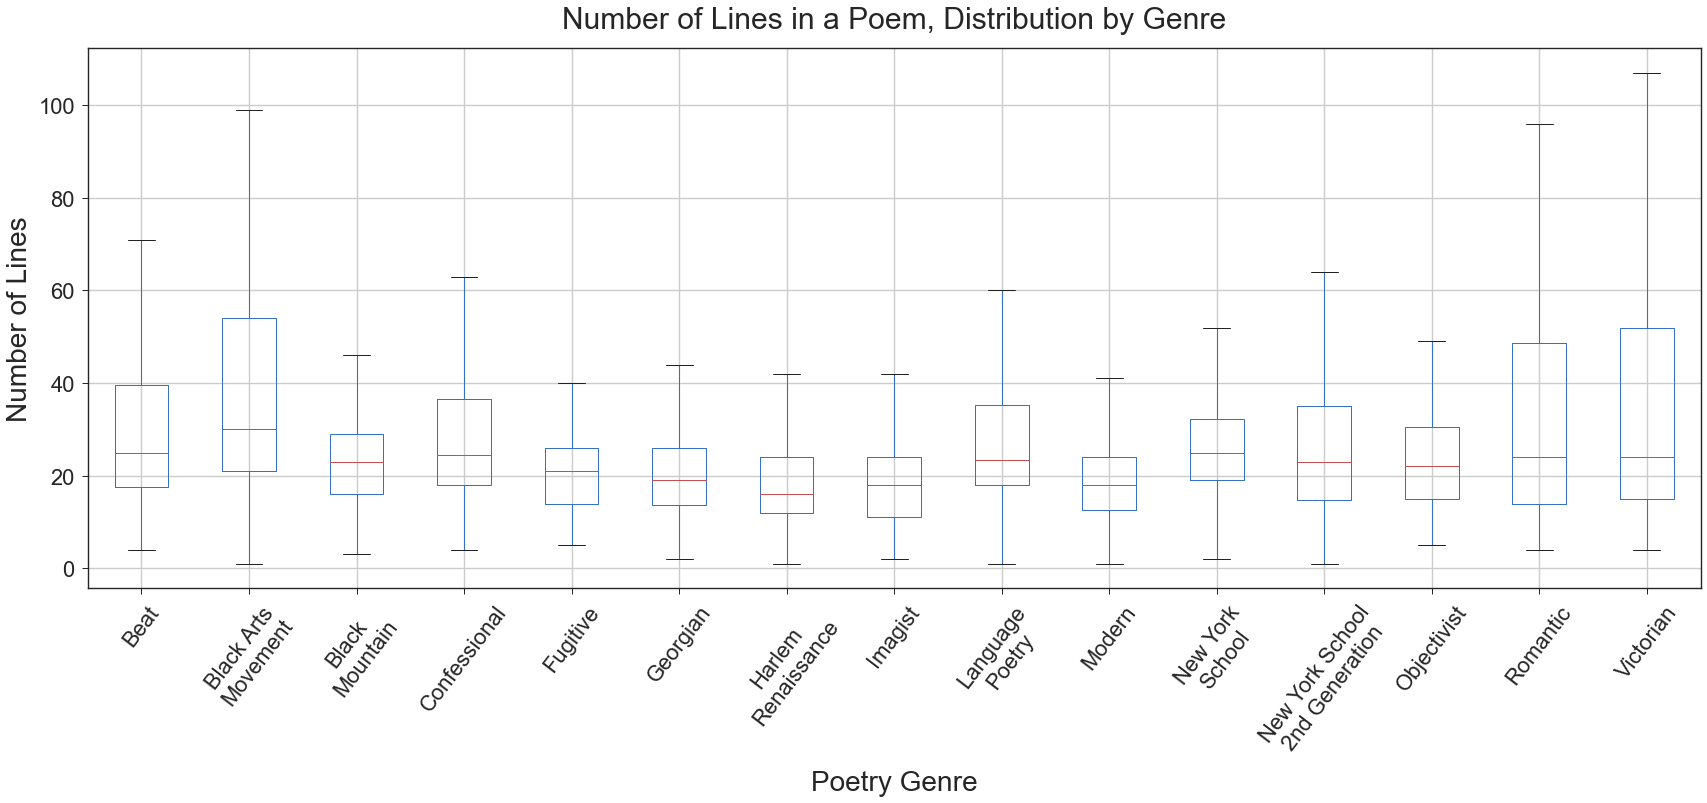

In [290]:
sns.set_style('ticks')

df.boxplot('num_lines', 'genre', showfliers=False, figsize=(28,10))
plt.title('Number of Lines in a Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Lines', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some promise here, though the medians look fairly similar

### Average Line Length -- Boxplot

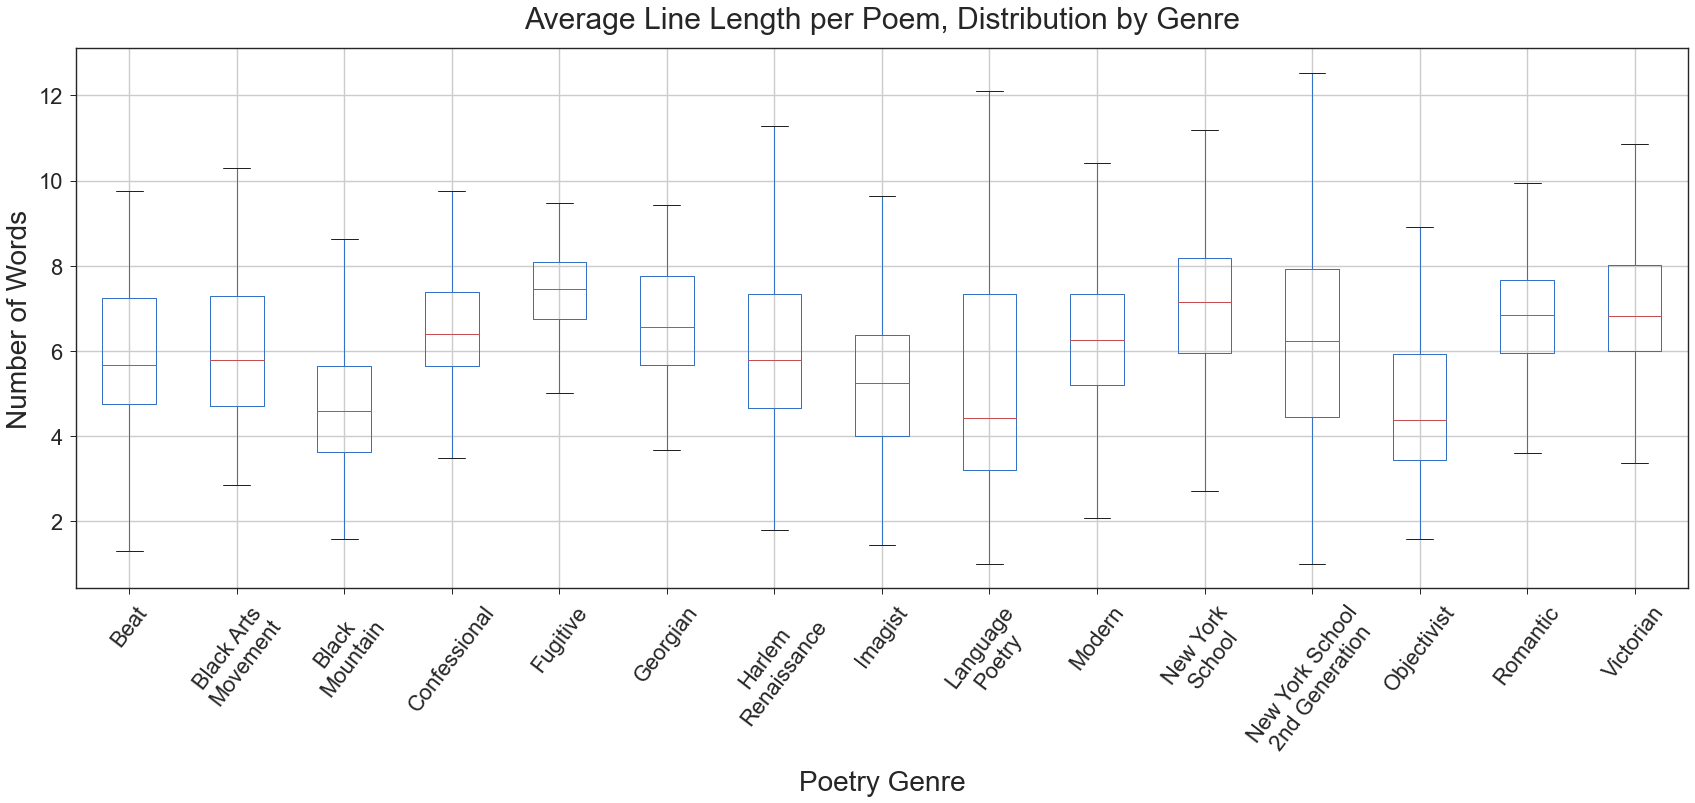

In [291]:
df.boxplot('avg_len_line', 'genre', showfliers=False, figsize=(28,10))
plt.title('Average Line Length per Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Words', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Definitely some promise here -- average line length appears to be very telling
### A look at polarity by genre

In [292]:
# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['poem_string'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [293]:
# may be handy to also have this as a categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, choices, 'neutral')

In [294]:
# polarity score by genre
df.groupby('genre').sentiment_polarity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,0.211505,0.019956,0.298936,0.082119,0.121377,0.038297,0.143196,0.269458,0.157053,0.211510,0.442634,0.367180,0.152358,0.511530,0.363730
std,0.751574,0.822611,0.640693,0.794445,0.753841,0.789306,0.750819,0.658530,0.654778,0.707653,0.661167,0.681735,0.694334,0.717514,0.785391
min,-0.999800,-0.999400,-0.998200,-0.997000,-0.996200,-0.998000,-0.998700,-0.997900,-0.996500,-0.998100,-0.985900,-0.998600,-0.992100,-0.999700,-0.999900
25%,-0.613250,-0.896800,-0.140600,-0.802525,-0.657175,-0.834350,-0.614775,-0.296000,-0.476700,-0.508550,-0.129600,-0.042200,-0.530850,0.254200,-0.517650
50%,0.434400,0.177900,0.510600,0.326200,0.318700,0.000000,0.327550,0.496100,0.279800,0.461200,0.797000,0.670500,0.273200,0.938800,0.868900
75%,0.925700,0.859100,0.864600,0.895650,0.888500,0.921150,0.880425,0.865650,0.789800,0.880950,0.952300,0.940300,0.818850,0.987700,0.980650
max,0.997600,0.998200,0.996300,0.999900,0.999600,0.998100,0.995900,0.997900,0.996100,0.999900,0.999700,0.999500,0.998100,1.000000,1.000000


### Polarity score -- Boxplot

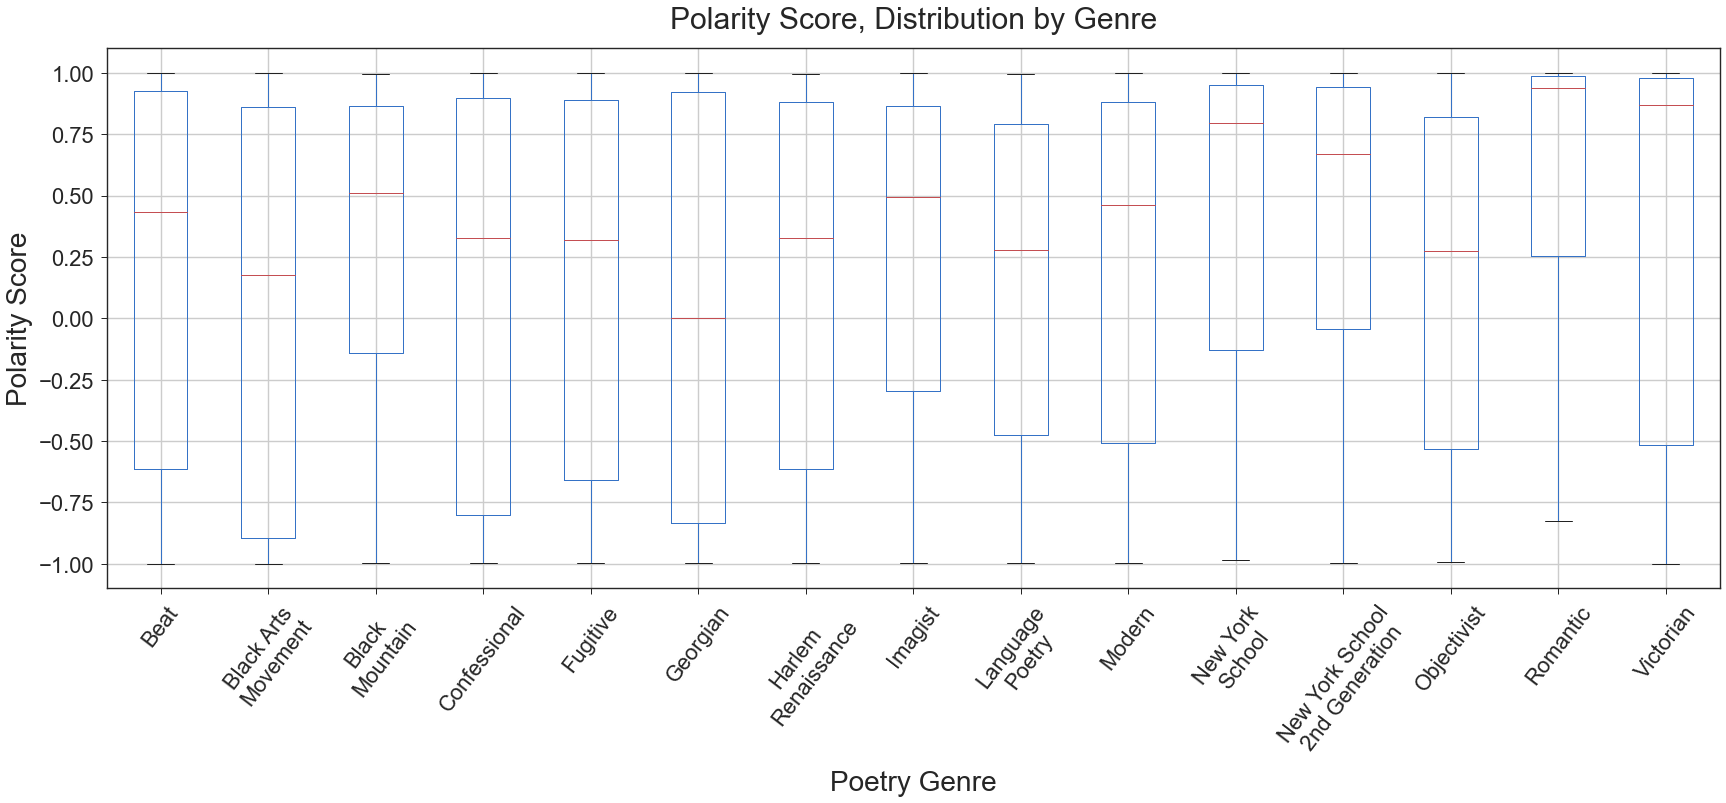

In [295]:
df.boxplot('sentiment_polarity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Polarity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Polarity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some definitely telling differences in polarity here

### Polarity -- Stacked bar chart

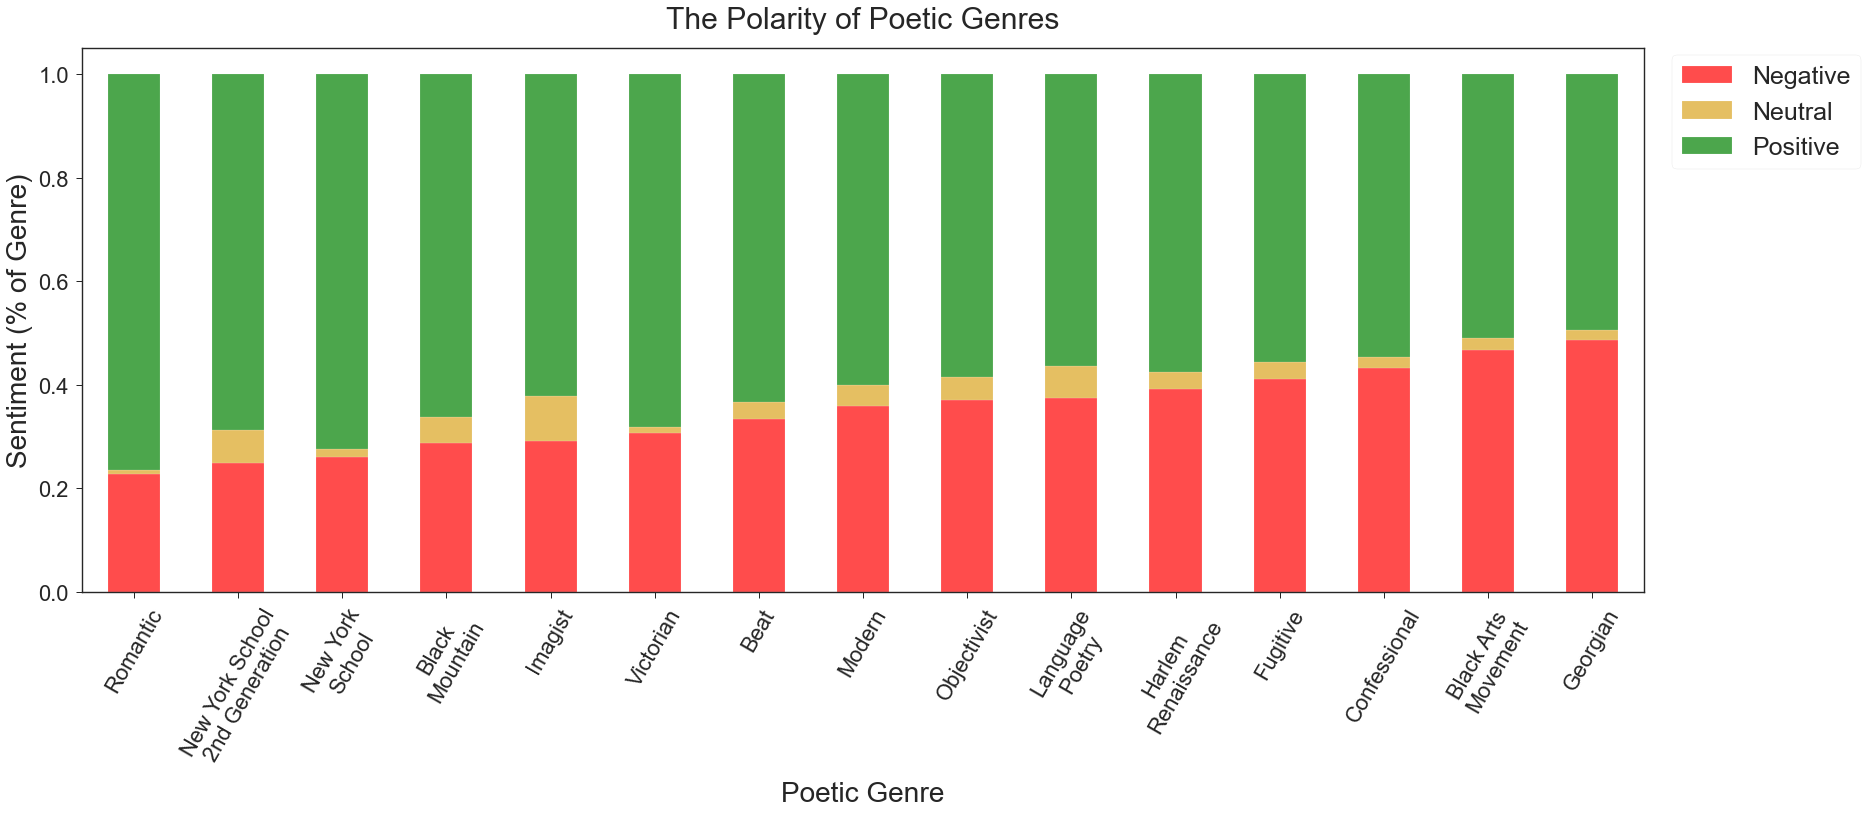

In [296]:
# Proportion of polarity across genre
genre_polarity_dist = df.groupby('genre').sentiment_polarity.value_counts(normalize=True).unstack().sort_values('negative')

genre_polarity_dist.plot(kind='bar', stacked = True, figsize=(28,10), 
                               color = ['red', 'goldenrod', 'green'], alpha = .70, fontsize=14)


plt.title('The Polarity of Poetic Genres', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetic Genre', fontsize=28, labelpad=10)
plt.ylabel('Sentiment (% of Genre)', fontsize=28, labelpad=5)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-2] = 'Black Arts\nMovement'
labels_pretty[2] = 'New York\nSchool'
labels_pretty[1] = 'New York School\n2nd Generation'

plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=22)

plt.yticks(fontsize=22);

plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=25);

#### Polarity differences made even more clear here

### A look at subjectivity by genre

In [297]:
# create a column with the compound polarity score, passing in the raw poem
df['sentiment_subjectivity_score'] = df['poem_string'].apply(lambda x: tb(x).sentiment.subjectivity)

# a look at subjectivity score overall
df.sentiment_subjectivity_score.describe()

count    4626.000000
mean        0.476474
std         0.141628
min         0.000000
25%         0.405556
50%         0.484001
75%         0.552169
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [298]:
# subjectivity score by genre
df.groupby('genre').sentiment_subjectivity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,0.485920,0.486905,0.473442,0.449826,0.452348,0.493294,0.461606,0.464208,0.452016,0.472870,0.478922,0.443955,0.467951,0.516769,0.489887
std,0.135374,0.129872,0.134837,0.095791,0.113385,0.135854,0.167038,0.178107,0.159750,0.155394,0.109665,0.161278,0.160679,0.111608,0.106527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.408879,0.405116,0.393194,0.396533,0.390881,0.421864,0.372917,0.378507,0.386667,0.393127,0.414705,0.396785,0.373066,0.462876,0.433333
50%,0.500000,0.495718,0.467163,0.455133,0.452803,0.493211,0.477050,0.466237,0.456692,0.483929,0.472457,0.465885,0.481250,0.517955,0.500000
75%,0.569556,0.548506,0.558163,0.516742,0.531264,0.568246,0.553571,0.567130,0.543769,0.558333,0.545418,0.526549,0.550000,0.569783,0.542774
max,1.000000,1.000000,1.000000,0.788889,0.683333,1.000000,0.888889,0.933333,1.000000,1.000000,1.000000,0.900000,1.000000,0.950000,0.944444


### Subjectivity score -- Boxplot

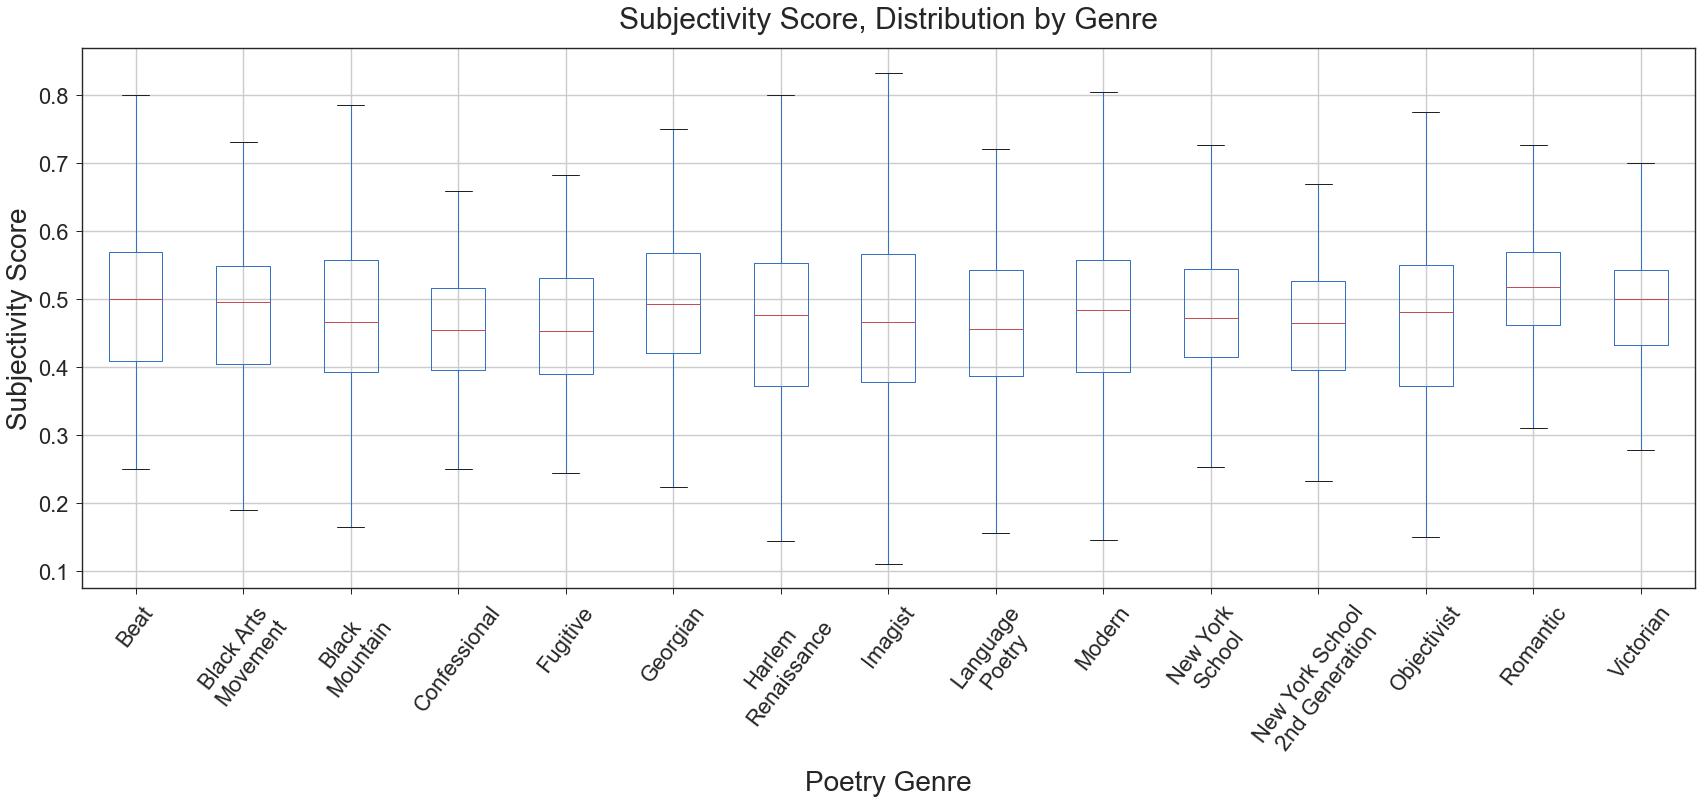

In [299]:
df.boxplot('sentiment_subjectivity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Subjectivity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Subjectivity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Subjectivity seems fairly similar across all genres
### DOES IT RHYME?

In [301]:
text = df.loc[4100,'clean_lines']
text

['Oh Galuppi, Baldassaro, this is very sad to find!',
 'I can hardly misconceive you; it would prove me deaf and blind;',
 "But although I take your meaning, 'tis with such a heavy mind!",
 "Here you come with your old music, and here's all the good it brings.",
 'What, they lived once thus at Venice where the merchants were the kings,',
 "Where Saint Mark's is, where the Doges used to wed the sea with rings?",
 "Ay, because the sea's the street there; and 'tis arched by . . . what you call",
 ". . . Shylock's bridge with houses on it, where they kept the carnival:",
 "I was never out of England—it's as if I saw it all.",
 'Did young people take their pleasure when the sea was warm in May?',
 'Balls and masks begun at midnight, burning ever to mid-day,',
 'When they made up fresh adventures for the morrow, do you say?',
 'Was a lady such a lady, cheeks so round and lips so red,—',
 'On her neck the small face buoyant, like a bell-flower on its bed,',
 "O'er the breast's superb abundanc

In [302]:
end_words = [line.split()[-1].translate(str.maketrans('', '', string.punctuation)) for line in text]
end_words

['find',
 'blind',
 'mind',
 'brings',
 'kings',
 'rings',
 'call',
 'carnival',
 'all',
 'May',
 'midday',
 'say',
 'red—',
 'bed',
 'head',
 'afford',
 'sword',
 'clavichord',
 'sigh',
 'die',
 'try',
 'you',
 'kisses—Did',
 'to',
 'say',
 'gay',
 'play',
 'one',
 'undone',
 'sun',
 'swerve',
 'reserve',
 'nerve',
 'burned',
 'earned',
 'discerned',
 'geology',
 'degree',
 'be',
 'drop',
 'crop',
 'stop',
 'scold',
 'gold',
 'old']

In [310]:
df['num_end_rhymes'] = df.clean_lines.apply(rhyme_endline_counter)

In [311]:
df.num_end_rhymes.describe()

count    4626.000000
mean       23.130350
std       153.972345
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max      4165.000000
Name: num_end_rhymes, dtype: float64

In [312]:
# subjectivity score by genre
df.groupby('genre').num_end_rhymes.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,6.979592,8.545455,3.509728,23.539773,9.588889,10.031250,8.912162,2.202247,5.453125,8.302580,3.761364,10.093750,3.396226,73.947236,78.353033
std,21.403965,16.852464,10.446707,107.065847,45.384474,13.013501,22.440224,7.961782,23.460067,67.141501,22.102592,38.840007,10.352043,323.200641,294.014275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000
50%,1.000000,2.000000,1.000000,3.000000,2.000000,6.000000,3.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,11.000000,13.000000
75%,3.000000,8.000000,2.000000,9.000000,6.750000,12.000000,7.250000,1.000000,3.000000,6.000000,3.000000,4.000000,2.000000,25.000000,36.000000
max,171.000000,120.000000,91.000000,925.000000,426.000000,112.000000,165.000000,86.000000,281.000000,2241.000000,352.000000,340.000000,97.000000,4165.000000,3734.000000


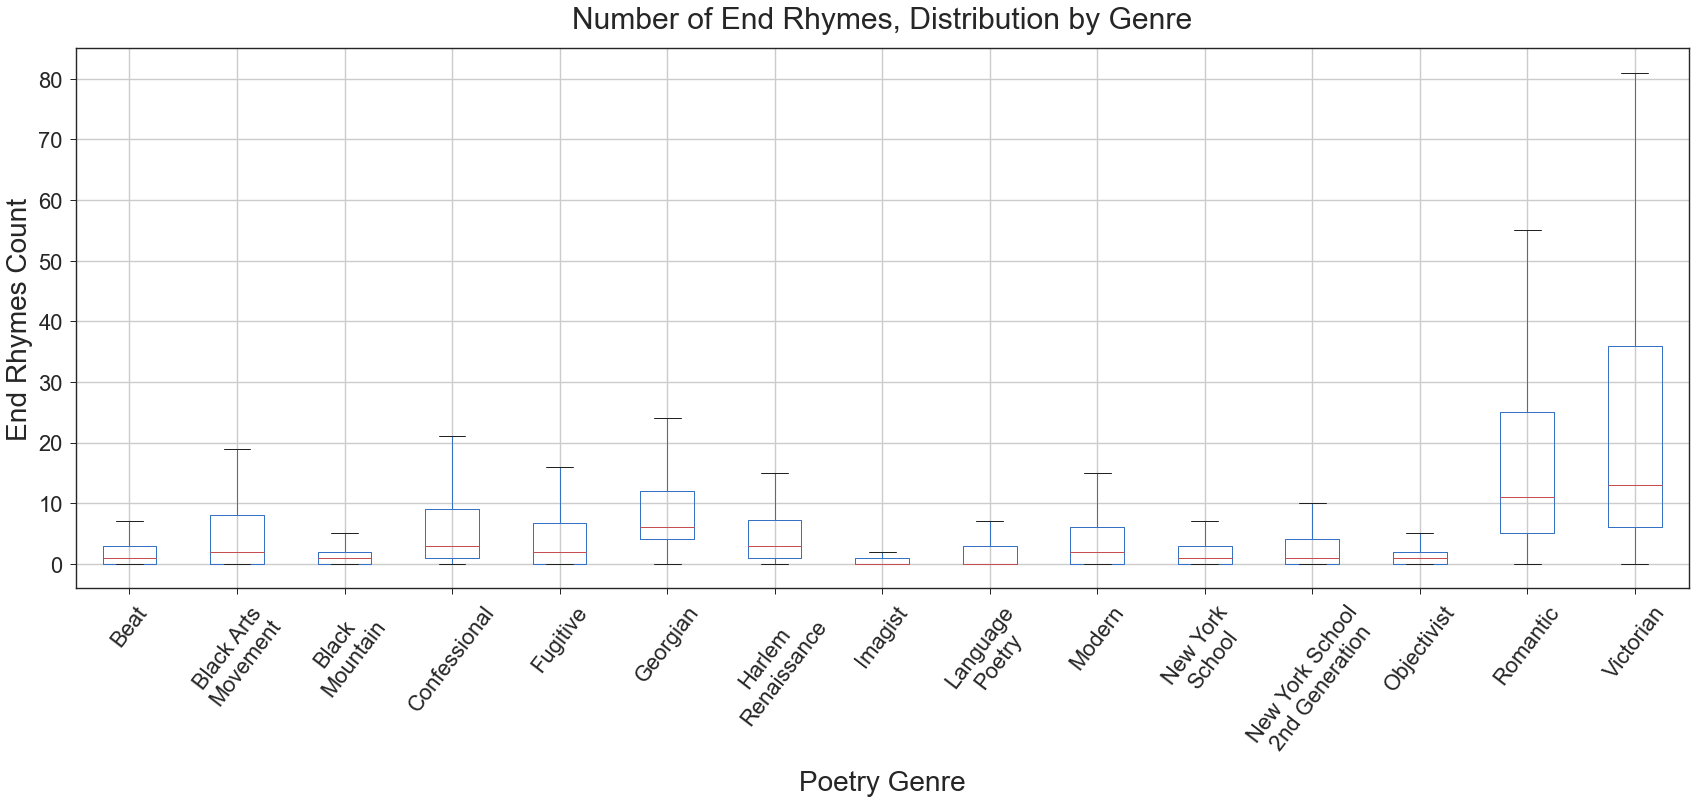

In [313]:
df.boxplot('num_end_rhymes', 'genre', showfliers=False, figsize=(28,10))
plt.title('Number of End Rhymes, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('End Rhymes Count', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

In [314]:
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_lines

In [316]:
df.end_rhyme_ratio.describe()

count    4626.000000
mean        0.287813
std         0.542488
min         0.000000
25%         0.000000
50%         0.125000
75%         0.384615
max        13.846154
Name: end_rhyme_ratio, dtype: float64

In [317]:
# subjectivity score by genre
df.groupby('genre').end_rhyme_ratio.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,0.111400,0.169917,0.070387,0.286760,0.207509,0.414954,0.270924,0.057574,0.062706,0.210880,0.068373,0.118893,0.052300,0.598382,0.783333
std,0.414644,0.308607,0.100100,0.790383,0.274450,0.332224,0.266837,0.131976,0.119465,0.263735,0.107944,0.285415,0.090645,0.631102,0.979743
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.033675,0.000000,0.250000,0.103947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.346875
50%,0.037037,0.057971,0.037037,0.121324,0.091667,0.355042,0.226496,0.000000,0.000000,0.136364,0.038462,0.050000,0.020408,0.477227,0.500000
75%,0.103807,0.195652,0.100000,0.316842,0.288750,0.536401,0.380952,0.056373,0.087276,0.322479,0.088235,0.132234,0.070197,0.706250,0.874313
max,4.800000,2.790698,0.600000,9.700000,1.322981,2.344828,1.918605,1.181818,0.866667,3.704132,0.919060,2.842105,0.733333,6.116006,13.846154


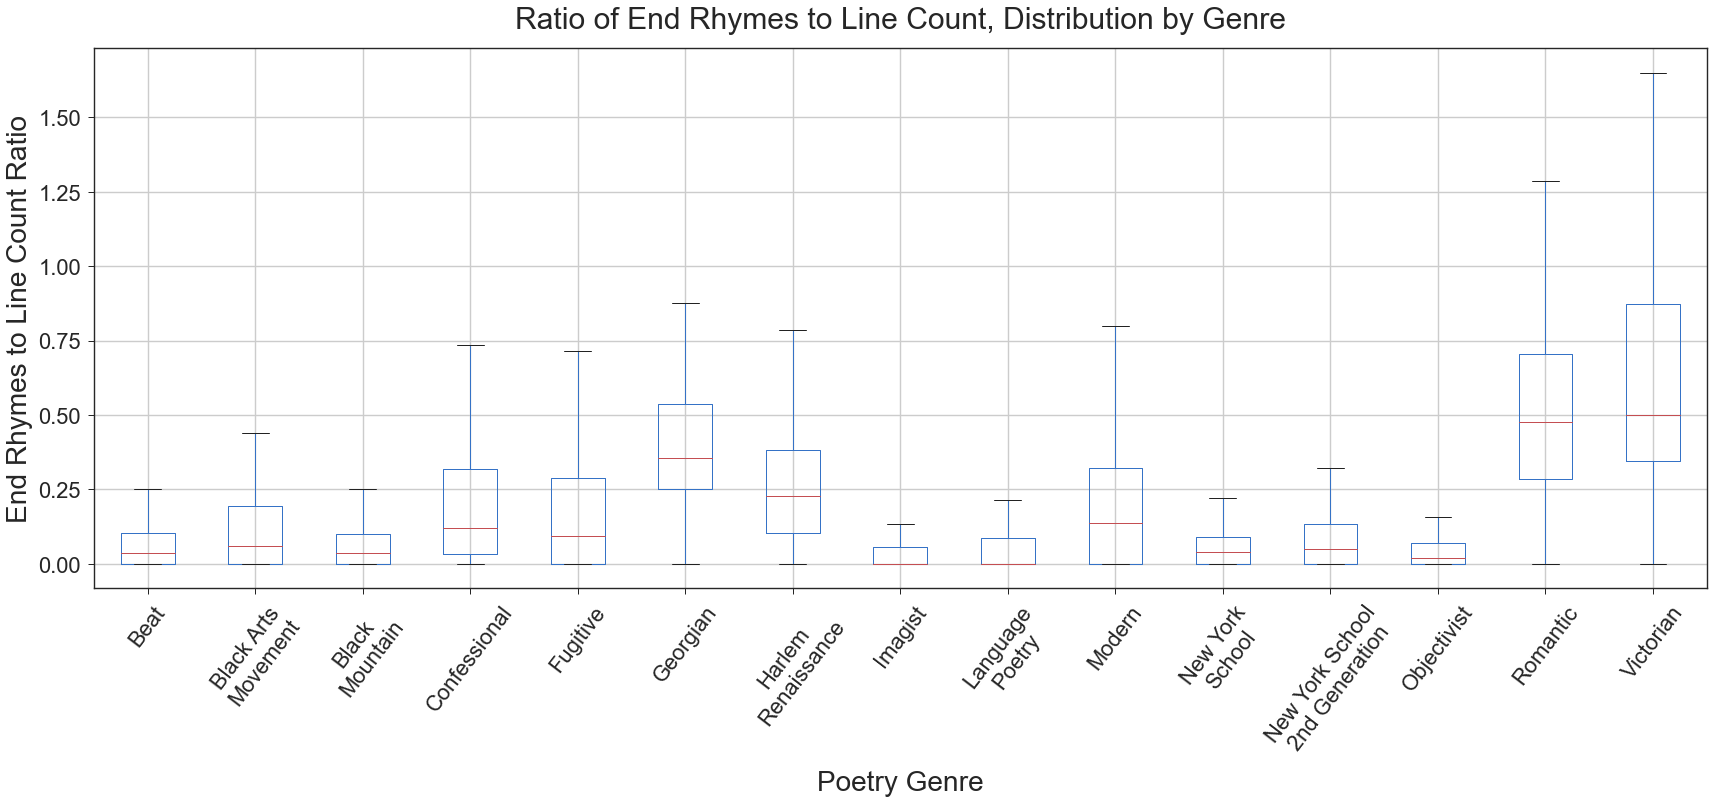

In [318]:
df.boxplot('end_rhyme_ratio', 'genre', showfliers=False, figsize=(28,10))
plt.title('Ratio of End Rhymes to Line Count, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('End Rhymes to Line Count Ratio', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

In [ ]:
df.drop(columns=['num'])

## Text Processing
#### First, let's save our dataframe (I'll be pickling now to try to avoid having to destringify columns)

In [321]:
# uncomment to save
with gzip.open('data/poetry_genres_df.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_genres_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

In [322]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_endline_rhymes',
       'endline_rhyme_ratio', 'num_end_rhymes', 'end_rhyme_ratio'],
      dtype='object')

#### Let's separate our target variable and create a features dataframe 

In [170]:
target = df['genre']
features = df[['title', 'clean_lines', 'num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_polarity',
               'sentiment_subjectivity_score']]

In [171]:
# since I'll be treating the title as part of the poem, combine title and lines
# NOTE: a pesky float ValueError solved by casting str() on values, even though it seems like everything was a string already
features['lines_titled'] = features['title'].apply(lambda x: [str(x)]) + features['clean_lines']
features.loc[2,'lines_titled']

['December 30',
 'At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [172]:
features['string_titled'] = features.lines_titled.apply(lambda x: ' '.join(x))
features.loc[2,'string_titled']

'December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on.'

#### Now we can drop the title and clean_lines columns

In [173]:
features.drop(columns=['title', 'clean_lines'], inplace=True)
features.columns

Index(['num_lines', 'avg_len_line', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'lines_titled',
       'string_titled'],
      dtype='object')

#### Prepare a list of stop words

In [174]:
# prepare a list of poet names to add to stop words list, because some may have gotten through in the scraping step
# first prepare a list of names that may also be used as words
name_keeps = ['basil', 'bell', 'bill', 'bottoms', 'brooks', 'brown', 'burns', 'butler', 'christian', 'clerk', 'crane',
              'elephant', 'field', 'gallup', 'good', 'guest', 'hands', 'hood', 'hooks', 'hunt', 'hunter', 'knight',
              'lamb', 'lazarus', 'love', 'mare', 'more', 'mark', 'moody', 'peacock', 'pound', 'ransom', 'riding',
              'savage', 'sir', 'white']
# optional = ['bob', 'dick', 'lee', 'maya', 'sappho', 'sexton', 'smith', 'spender', 'twain', 'walker']

stop_names = set()
for poet in df.poet:
    name_split = poet.lower().split()
    for name in name_split:
        if name not in name_keeps:
            stop_names.add(name)
stop_names = list(stop_names)
stop_names[:10]

['mina',
 'g.',
 'mary',
 'babette',
 'conan',
 'john',
 'ron',
 'wadsworth',
 'ashbery',
 'cummings']

In [192]:
# start with NLTK stop words
stop_words = stopwords.words('english')
# add any html tags that may have snuck through
stop_words.extend(['em','div', 'href', 'p'])
# add old-timey stop words (modified from Bryan Bumgardner's: https://bryanbumgardner.com/elizabethan-stop-words-for-nlp/)
stop_words.extend(['doth', 'dost', 'ere', 'hast', 'hath', 'hence', 'hither', 'nigh', 'oft', "should'st", 'thither',
                   'tither', 'thee', 'thou', 'thine', 'thy', 'tis', 'twas', 'wast', 'whence', 'wherefore', 'whereto', 
                   'withal', "would'st", 'ye', 'yon', 'yonder'])
# let's include some words found in the initial round of EDA that probably don't give us much meaning
stop_words.extend(['like', 'would', 'shall', 'upon', 'yet', 'may', 'could'])
# and don't forget to include the names from above
stop_words.extend(stop_names)

#### Create a clean string column

In [193]:
features['string_cleaned'] = features.string_titled.apply(lambda x: clean_text(x, stop_words))

In [194]:
# check out an example
print(f"BEFORE:\n{features.iloc[2,6]}")
print('\n' + '-' * 100 + '\n')
print(f"AFTER:\n{features.iloc[2,7]}")

BEFORE:
December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on.

----------------------------------------------------------------------------------------------------

AFTER:
december morning fart smell marriage avocado fish head get bed write without glass


In [195]:
# check out an example
print(f"BEFORE:\n{features.iloc[4444,6]}\n")
print('-' * 100)
print(f"\nAFTER:\n{features.iloc[4444,7]}")

BEFORE:
When I am dead, my dearest When I am dead, my dearest, Sing no sad songs for me; Plant thou no roses at my head, Nor shady cypress tree: Be the green grass above me With showers and dewdrops wet; And if thou wilt, remember, And if thou wilt, forget. I shall not see the shadows, I shall not feel the rain; I shall not hear the nightingale Sing on, as if in pain: And dreaming through the twilight That doth not rise nor set, Haply I may remember, And haply may forget.

----------------------------------------------------------------------------------------------------

AFTER:
dead dearest dead dearest sing sad song plant rose head shady cypress tree green grass shower dewdrop wet wilt remember wilt forget see shadow feel rain hear nightingale sing pain dream twilight rise set haply remember haply forget


## SAVE/LOAD
#### both target series and features dataframe

In [2]:
# # SAVE
# # uncomment to save target series
# with gzip.open('data/target_genres.pkl', 'wb') as goodbye1:
#     pickle.dump(target, goodbye1, protocol=pickle.HIGHEST_PROTOCOL)
# # uncomment to save features dataframe
# with gzip.open('data/features.pkl', 'wb') as goodbye2:
#     pickle.dump(features, goodbye2, protocol=pickle.HIGHEST_PROTOCOL)

# # LOAD
# # uncomment to load target series
# with gzip.open('data/target_genres.pkl', 'rb') as hello1:
#     target = pickle.load(hello1)
# # uncomment to load features dataframe
# with gzip.open('data/features.pkl', 'rb') as hello2:
#     features = pickle.load(hello2)

#### Let's see how many words and unique words we have in the dataset

In [196]:
# Join all cleaned tweets into one string
big_string = ' '.join(features.string_titled)
big_string[:1000]

'At the California Institute of Technology I don’t care how God-damn smart these guys are: I’m bored. It’s been raining like hell all day long and there’s nothing to do. A Boat O beautiful was the werewolf in his evil forest. We took him to the carnival and he started crying when he saw the Ferris wheel. Electric green and red tears flowed down his furry cheeks. He looked like a boat out on the dark water. December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on. The Double-Bed Dream Gallows Driving through hot brushy country in the late autumn, I saw a hawk crucified on a barbed-wire fence. I guess as a kind of advertisement to other hawks, saying from the pages of a leading women’s magazine, “She’s beautiful, but burn all the maps to your body. I’m not here of my own choosing.” Haiku Ambulance A piece of green pepper fell off the wooden salad bowl: so what? I Feel Horrible. S

In [197]:
# Split string into all words in clean tweets
all_words = big_string.split()

# total words
len(all_words)

1081286

In [198]:
# unique words
len(list(set(all_words)))

114075

#### Now let's do the same on our cleaned text (after lemmatizing and removing stop words)

In [199]:
# Join all cleaned tweets into one string
big_string = ' '.join(features.string_cleaned)
big_string[:1000]

'california institute technology care god damn smart guy bore rain hell day long nothing boat beautiful werewolf evil forest take carnival start cry saw ferris wheel electric green red tear flow furry cheek look boat dark water december morning fart smell marriage avocado fish head get bed write without glass double bed dream gallows drive hot brushy country late autumn saw hawk crucify barbed wire fence guess kind advertisement hawk say page lead woman magazine beautiful burn map body choose haiku ambulance piece green pepper fell wooden salad bowl feel horrible feel horrible love wander around house sew machine finish sew turd garbage lid mating saliva girl green mini skirt pretty walk street businessman stop turn stare look moldy refrigerator people america pill versus springhill mine disaster take pill mine disaster think people lose inside poker star star look poker game mountain eastern oregon three men play sheepherder one two pair others nothing private eye lettuce three crate 

In [200]:
# Split string into all words in clean tweets
all_words = big_string.split()

# total words
len(all_words)

547666

In [201]:
# unique words
len(list(set(all_words)))

33710

In [202]:
# Create dictionary of word counts
fdist = FreqDist(all_words)
fdist

FreqDist({'one': 3713, 'love': 3084, 'come': 3042, 'say': 2658, 'day': 2445, 'see': 2392, 'make': 2366, 'eye': 2205, 'know': 2105, 'life': 2065, ...})

In [203]:
# Convert word counts to dataframe
fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
fdist_df = fdist_df.sort_values('word_count', ascending=False)

In [204]:
top_25 = fdist_df.iloc[:25,:]
top_25

,word_count
one,3713
love,3084
come,3042
say,2658
day,2445
see,2392
make,2366
eye,2205
know,2105
life,2065


In [205]:
top_50 = fdist_df.iloc[:50]
top_50

,word_count
one,3713
love,3084
come,3042
say,2658
day,2445
see,2392
make,2366
eye,2205
know,2105
life,2065


<BarContainer object of 25 artists>

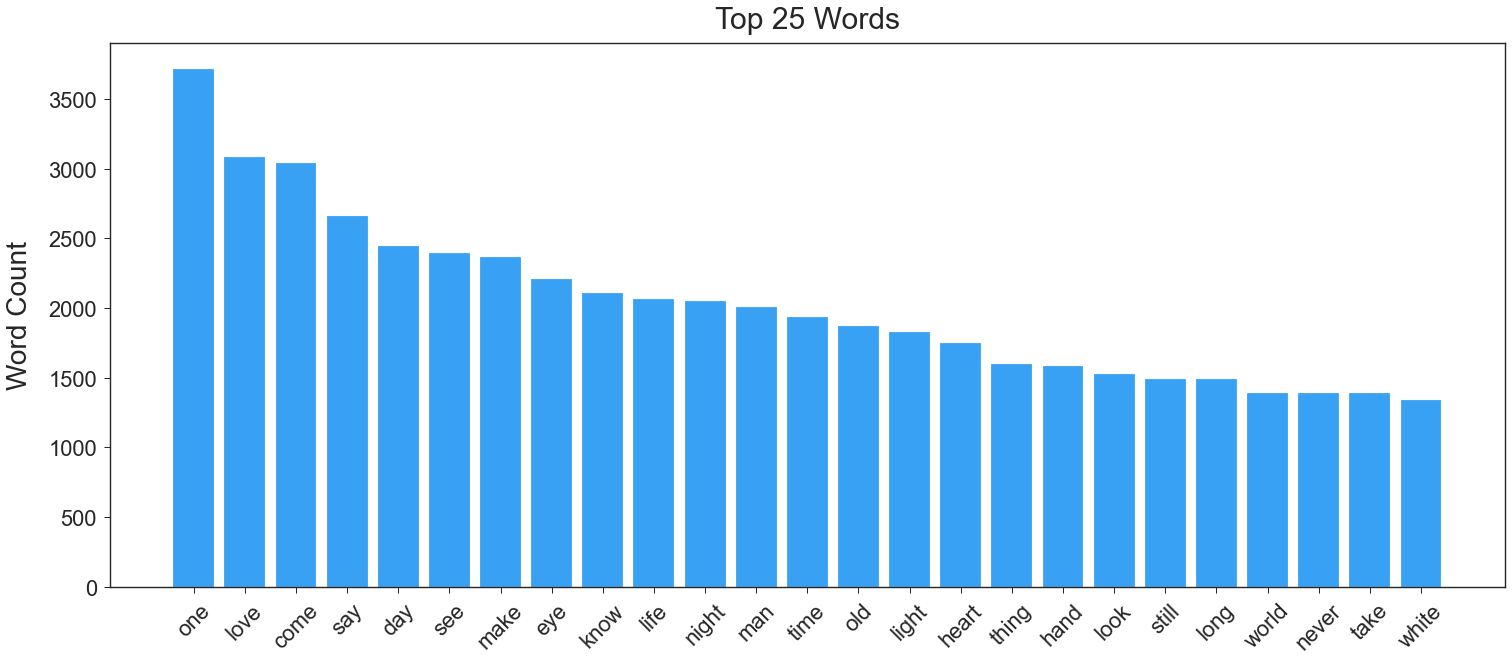

In [206]:
plt.figure(figsize=(25,10))
plt.title('Top 25 Words', fontsize=30, pad=15)
plt.ylabel('Word Count', fontsize=28, labelpad=15)
plt.xticks(rotation=45, fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(bottom=15000, top=41000)

plt.bar(top_25.index, top_25.word_count, color='#38A1F3')

# plt.savefig('Images/top_25_words.png', dpi = 100)

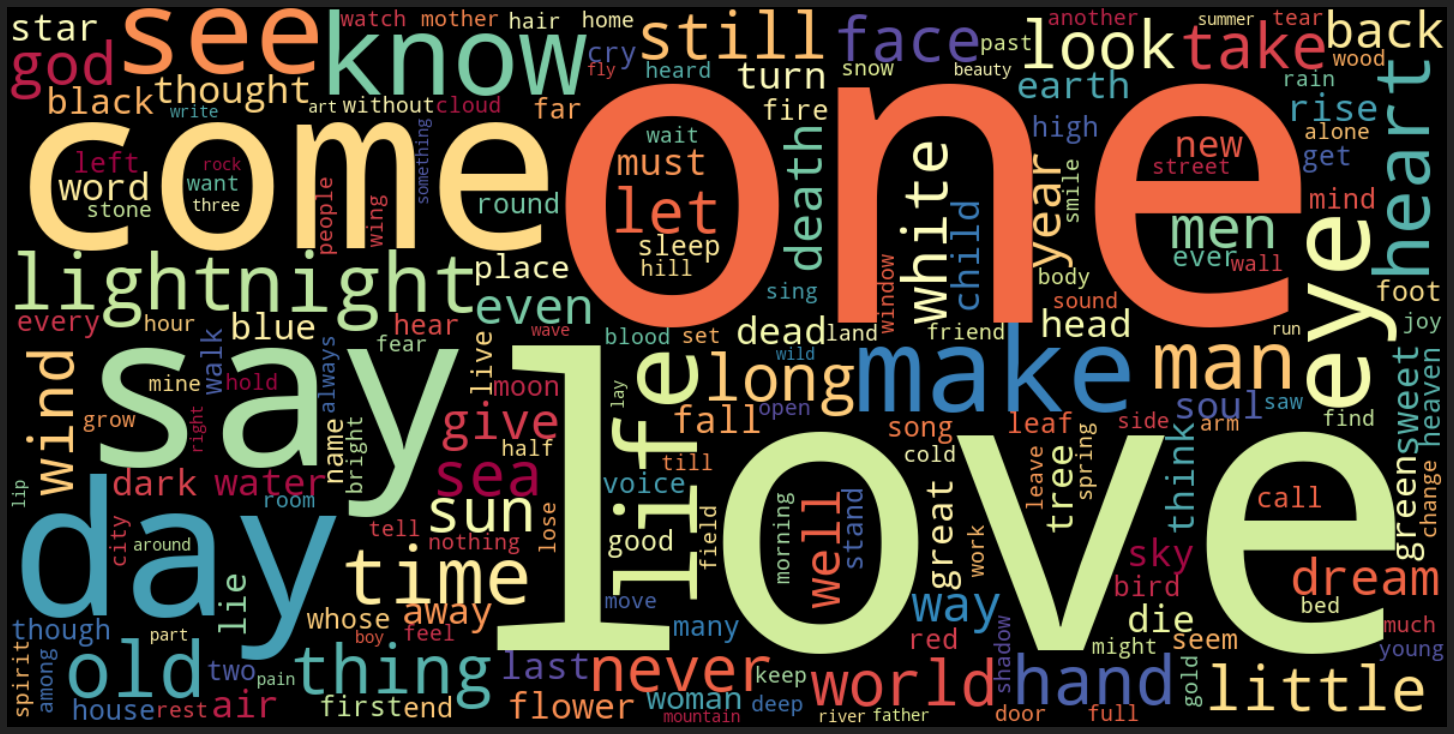

In [207]:
# Word cloud
word_dict = dict(Counter(all_words))
wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).generate_from_frequencies(word_dict)

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

### Trim dataframe

In [100]:
df = pd.concat([target, features], axis=1)
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
language_poetry                    192
new_york_school_2nd_generation     192
confessional                       176
black_arts_movement                165
georgian                           160
objectivist                        159
harlem_renaissance                 148
beat                               147
fugitive                            90
Name: genre, dtype: int64

In [101]:
df.genre.value_counts(normalize=True).cumsum()

modern                            0.276481
victorian                         0.415478
romantic                          0.501513
imagist                           0.578470
new_york_school                   0.635538
black_mountain                    0.691094
language_poetry                   0.732598
new_york_school_2nd_generation    0.774103
confessional                      0.812149
black_arts_movement               0.847817
georgian                          0.882404
objectivist                       0.916775
harlem_renaissance                0.948768
beat                              0.980545
fugitive                          1.000000
Name: genre, dtype: float64

In [102]:
top8 = list(df.genre.value_counts().keys())[:8]
top8

['modern',
 'victorian',
 'romantic',
 'imagist',
 'new_york_school',
 'black_mountain',
 'language_poetry',
 'new_york_school_2nd_generation']

In [103]:
df.shape

(4626, 9)

In [104]:
df_top = df[df.genre.isin(top8)]
df_top.shape

(3581, 9)

In [105]:
df_top.genre.value_counts(normalize=True)

modern                            0.357163
victorian                         0.179559
romantic                          0.111142
imagist                           0.099414
new_york_school                   0.073722
black_mountain                    0.071768
language_poetry                   0.053616
new_york_school_2nd_generation    0.053616
Name: genre, dtype: float64

### TF-IDF Vectorizer and a baseline model

In [85]:
X = df_top.string_cleaned
y = df_top.genre

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2685,) (2685,)
(896,) (896,)


In [88]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data and transform 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [89]:
bnb_baseline = BernoulliNB()
bnb_baseline.fit(X_train_vec, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [95]:
# predict the new document from the testing dataset
y_preds = bnb_baseline.predict(X_test_vec)

# compute the performance measures
bnb_baseline_acc = accuracy_score(y_test, y_preds)
bnb_baseline_f1 = f1_score(y_test, y_preds, average='weighted')

print(f'Accuracy: {bnb_baseline_acc}')
print(f'F1 score: {bnb_baseline_f1}')

print('\n' + '-' * 100 + '\n')

print(classification_report(y_test, y_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

print("confusion matrix:")
print(confusion_matrix(y_test, y_preds))

Accuracy: 0.4185267857142857
F1 score: 0.3066799940565512

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                black_mountain       0.00      0.00      0.00        64
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.40      0.95      0.56       320
               new_york_school       0.43      0.05      0.08        66
new_york_school_2nd_generation       0.00      0.00      0.00        48
                      romantic       0.74      0.17      0.28       100
                     victorian       0.49      0.32      0.38       161

                      accuracy                           0.42       896
                     macro avg       0.26      0.19      0.16       896
                  weighted avg       0.34    

### Let's try vectorizing beforehand

In [106]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data and transform 
X_vec = vectorizer.fit_transform(X)

In [107]:
X = pd.DataFrame.sparse.from_spmatrix(X_vec)
y = df_top.genre

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2685, 29071) (2685,)
(896, 29071) (896,)


In [109]:
bnb_baseline = BernoulliNB()
bnb_baseline.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [110]:
# predict the new document from the testing dataset
y_preds = bnb_baseline.predict(X_test)

# compute the performance measures
bnb_baseline_acc = accuracy_score(y_test, y_preds)
bnb_baseline_f1 = f1_score(y_test, y_preds, average='weighted')

print(f'Accuracy: {bnb_baseline_acc}')
print(f'F1 score: {bnb_baseline_f1}')

print('\n' + '-' * 100 + '\n')

print(classification_report(y_test, y_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

print("confusion matrix:")
print(confusion_matrix(y_test, y_preds))

Accuracy: 0.4185267857142857
F1 score: 0.3091634074765515

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                black_mountain       0.00      0.00      0.00        64
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.40      0.95      0.56       320
               new_york_school       0.50      0.06      0.11        66
new_york_school_2nd_generation       0.00      0.00      0.00        48
                      romantic       0.72      0.18      0.29       100
                     victorian       0.50      0.31      0.38       161

                      accuracy                           0.42       896
                     macro avg       0.26      0.19      0.17       896
                  weighted avg       0.35    

In [111]:
X = df.string_cleaned
y = df.genre

In [112]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data and transform 
X_vec = vectorizer.fit_transform(X)

In [115]:
X = pd.DataFrame.sparse.from_spmatrix(X_vec)
y = df.genre

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3469, 33601) (3469,)
(1157, 33601) (1157,)


In [117]:
bnb_baseline = BernoulliNB()
bnb_baseline.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [118]:
# predict the new document from the testing dataset
y_preds = bnb_baseline.predict(X_test)

# compute the performance measures
bnb_baseline_acc = accuracy_score(y_test, y_preds)
bnb_baseline_f1 = f1_score(y_test, y_preds, average='weighted')

print(f'Accuracy: {bnb_baseline_acc}')
print(f'F1 score: {bnb_baseline_f1}')

print('\n' + '-' * 100 + '\n')

print(classification_report(y_test, y_preds, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

print("confusion matrix:")
print(confusion_matrix(y_test, y_preds))

Accuracy: 0.3258426966292135
F1 score: 0.20751508358921916

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.25      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.00      0.00      0.00        64
                  confessional       0.00      0.00      0.00        44
                      fugitive       0.00      0.00      0.00        22
                      georgian       0.00      0.00      0.00        40
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern       0.31      0.95      0.46       320
               new_york_school       0.29    

In [7]:
len(vectorizer.vocabulary_.keys())

33601

In [9]:
vectorizer.vocabulary_

{'california': 4308,
 'institute': 15275,
 'technology': 28803,
 'care': 4510,
 'god': 12501,
 'damn': 7246,
 'smart': 26612,
 'guy': 13071,
 'bore': 3493,
 'rain': 23363,
 'like': 16996,
 'hell': 13618,
 'day': 7362,
 'long': 17281,
 'nothing': 19932,
 'boat': 3334,
 'beautiful': 2501,
 'werewolf': 32587,
 'evil': 10115,
 'forest': 11435,
 'take': 28596,
 'carnival': 4545,
 'start': 27474,
 'cry': 6996,
 'saw': 25149,
 'ferris': 10778,
 'wheel': 32644,
 'electric': 9287,
 'green': 12804,
 'red': 23721,
 'tear': 28784,
 'flow': 11221,
 'furry': 11876,
 'cheek': 5037,
 'look': 17299,
 'dark': 7306,
 'water': 32394,
 'december': 7463,
 'morning': 19064,
 'fart': 10575,
 'smell': 26622,
 'marriage': 18012,
 'avocado': 1980,
 'fish': 10989,
 'head': 13476,
 'get': 12227,
 'bed': 2525,
 'write': 33262,
 'without': 33031,
 'glass': 12371,
 'double': 8622,
 'dream': 8742,
 'gallows': 11964,
 'drive': 8798,
 'hot': 14170,
 'brushy': 3957,
 'country': 6638,
 'late': 16604,
 'autumn': 1939,
 'ha

In [10]:
vectorizer.idf_

array([8.3410517 , 8.74651681, 8.74651681, ..., 8.74651681, 8.74651681,
       8.74651681])

In [ ]:

# list of text documents
text = features.string_cleaned
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())